# Binary Sentiment Analysis System for Daraz E-commerce Reviews

## Project Overview
- **Task**: Binary sentiment classification
- **Labels**: -1 (Negative), 1 (Positive)
- **Dataset**: ~16,990 reviews in English + Roman Urdu
- **Approach**: Scikit-learn with TF-IDF vectorization

# STEP 1: IMPORT ALL REQUIRED LIBRARIES

In [51]:
# Data manipulation
import pandas as pd
import numpy as np

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Text vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Model training (SVM only)
from sklearn.svm import SVC

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Download required NLTK datasets
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

print("✓ All libraries imported successfully!")


✓ All libraries imported successfully!


# STEP 2: READ AND LOAD THE DATASET

In [52]:
# Read the CSV file using pandas
df = pd.read_csv('./dataset/daraz-code-mixed-product-reviews.csv')

# Convert text labels to numeric labels (BINARY CLASSIFICATION ONLY)
# negative -> -1, positive -> 1
# Note: We will remove neutral reviews to achieve binary classification
label_mapping = {'negative': -1, 'positive': 1, 'neutral': 0}
df['label'] = df['Sentiments'].map(label_mapping)

# Rename 'Reviews' column to 'reviews' for consistency
df = df.rename(columns={'Reviews': 'reviews'})

# Display basic information about the dataset
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nDataset Shape (including neutral): {df.shape}")
print(f"Number of Reviews: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")

# Display first few rows
print("\nFirst 3 rows of dataset:")
print(df[['reviews', 'label']].head(3))

# Display column names
print(f"\nColumn Names: {list(df.columns)}")

# Display data types
print("\nData Types:")
print(df.dtypes)

# Display label distribution (including neutral for reference)
print("\nLabel Distribution (Before Binary Classification):")
print(df['label'].value_counts().sort_index())
print("\nLabel Distribution Percentage:")
print((df['label'].value_counts().sort_index() / len(df) * 100).round(2))
print("\nNote: Neutral (0) will be removed in Step 3 for binary classification")


DATASET OVERVIEW

Dataset Shape (including neutral): (16990, 3)
Number of Reviews: 16990
Number of Columns: 3

First 3 rows of dataset:
                                             reviews  label
0  Stuff and design was totally changed. cheap qu...     -1
1  i got my parxel before time,sorry for late rev...      1
2  So far so good..... Bought it only because it ...      1

Column Names: ['Sentiments', 'reviews', 'label']

Data Types:
Sentiments    object
reviews       object
label          int64
dtype: object

Label Distribution (Before Binary Classification):
label
-1     4362
 0     2461
 1    10167
Name: count, dtype: int64

Label Distribution Percentage:
label
-1    25.67
 0    14.48
 1    59.84
Name: count, dtype: float64

Note: Neutral (0) will be removed in Step 3 for binary classification


# STEP 3: HANDLE MISSING VALUES

In [53]:
print("\n" + "=" * 60)
print("HANDLING MISSING VALUES & REMOVING NEUTRAL CLASS")
print("=" * 60)

# Check for missing values in each column
print("\nMissing Values Before Handling:")
print(df.isnull().sum())

# Remove rows with missing values
df = df.dropna()

# Remove neutral class (label = 0) to convert to binary classification
df = df[df['label'] != 0]

print(f"\nDataset Shape After Removing Missing Values & Neutral Class: {df.shape}")
print("Missing Values After Handling:")
print(df.isnull().sum())
print("\n✓ Missing values and neutral class removed successfully!")
print(f"Remaining classes: {sorted(df['label'].unique())}")


HANDLING MISSING VALUES & REMOVING NEUTRAL CLASS

Missing Values Before Handling:
Sentiments    0
reviews       0
label         0
dtype: int64

Dataset Shape After Removing Missing Values & Neutral Class: (14529, 3)
Missing Values After Handling:
Sentiments    0
reviews       0
label         0
dtype: int64

✓ Missing values and neutral class removed successfully!
Remaining classes: [np.int64(-1), np.int64(1)]


# STEP 4: TEXT PREPROCESSING FUNCTION

In [54]:
# This function applies all preprocessing steps in the correct order

def preprocess_text(text):
    """
    Comprehensive text preprocessing function for code-mixed text
    (English + Roman Urdu)
    
    Steps Applied (in order):
    1. Remove Emojis & Unicode: Clean emoji and special unicode characters
    2. Lowercase: Convert all text to lowercase for consistency
    3. Remove Special Characters: Keep only alphanumeric and spaces
    4. Remove Numbers: Remove all digit characters
    5. Remove URLs: Remove hyperlinks
    6. Extra Whitespace: Remove extra spaces
    7. Tokenization: Split text into individual words
    8. Remove Stopwords: Remove common words (the, is, a, etc.)
    9. Lemmatization: Convert words to base form
    """
    
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Step 1: REMOVE EMOJIS & SPECIAL UNICODE CHARACTERS
    # Remove emoji and special characters while keeping basic text
    text = text.encode('ascii', 'ignore').decode('ascii')
    
    # Step 2: LOWERCASE all text
    # Example: "REVIEW" -> "review"
    text = text.lower()
    
    # Step 3: REMOVE URLs
    # Remove links and web addresses
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Step 4: REMOVE SPECIAL CHARACTERS
    # Keep only letters, spaces, and apostrophes
    # Example: "don't" -> "don't", "review#" -> "review"
    text = re.sub(r'[^a-z\s\']', '', text)
    
    # Step 5: REMOVE NUMBERS
    # Example: "review123abc" -> "reviewabc"
    text = re.sub(r'\d+', '', text)
    
    # Step 6: REMOVE EXTRA WHITESPACE
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Step 7: TOKENIZATION (split into words)
    # Example: "good product quality" -> ["good", "product", "quality"]
    tokens = word_tokenize(text)
    
    # Step 8: REMOVE STOPWORDS
    # Stopwords are common words that don't carry much meaning
    stop_words = set(stopwords.words('english'))

    # Retain negation words to preserve sentiment context
    # Negations for English and Roman Urdu
    negations = {
        # English negations
        "not", "no", "never", "n't", "dont", "doesn't", "isn't", "aren't", 
        "wasn't", "weren't", "haven't", "hasn't", "hadn't", "shouldn't", "wouldn't",
        
        # Roman Urdu / Hindi-Urdu negations (most common)
        "nahi", "nhi", "nahin", "nhein", "nehi",      # "نہیں" - main negation ("not")
        "na", "nah", "nahiin",                         # "نہ" - prohibitive or poetic "no/not"
        "mat", "mut", "mt",                            # "مت" - "don't" (imperative prohibition)
        "kabhi", "kabhie", "kbhi", "kabi",             # "کبھی" - with nahi = "never"
        "koi",                                         # "کوئی" - with nahi = "no one/nothing"
        "bilkul",                                      # "بالکل" - with nahi = "not at all"
        "zarra", "zara"                                # "ذرہ" - with nahi = "not even a bit"
    }

    stop_words = stop_words - negations
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    
    # Step 9: LEMMATIZATION
    # Convert words to their base form
    # Example: "running" -> "run", "better" -> "good"
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a single string
    processed_text = ' '.join(tokens)
    
    return processed_text

# Example: Show preprocessing before and after
print("=" * 60)
print("TEXT PREPROCESSING EXAMPLE (Code-Mixed Text)")
print("=" * 60)
sample_text = df['reviews'].iloc[0]
print(f"\nOriginal Review:\n{sample_text}")
print(f"\nPreprocessed Review:\n{preprocess_text(sample_text)}")


TEXT PREPROCESSING EXAMPLE (Code-Mixed Text)

Original Review:
Stuff and design was totally changed. cheap quality 😐 not satisfied

Preprocessed Review:
stuff design totally changed cheap quality not satisfied


# STEP 5: APPLY PREPROCESSING TO ALL REVIEWS

In [55]:
print("\n" + "=" * 60)
print("APPLYING PREPROCESSING TO ALL REVIEWS")
print("=" * 60)

# Apply preprocessing function to all reviews
# This may take 1-2 minutes for 22,000 reviews
print("\nProcessing all reviews... (this may take a minute)")

df['processed_reviews'] = df['reviews'].apply(preprocess_text)

print(f"✓ Preprocessing completed for {len(df)} reviews")

# Show comparison
print("\nPreprocessing Results (first 3 reviews):")
for idx in range(3):
    print(f"\nReview {idx + 1}:")
    print(f"  Original: {df['reviews'].iloc[idx][:100]}...")
    print(f"  Processed: {df['processed_reviews'].iloc[idx][:100]}...")



APPLYING PREPROCESSING TO ALL REVIEWS

Processing all reviews... (this may take a minute)
✓ Preprocessing completed for 14529 reviews

Preprocessing Results (first 3 reviews):

Review 1:
  Original: Stuff and design was totally changed. cheap quality 😐 not satisfied...
  Processed: stuff design totally changed cheap quality not satisfied...

Review 2:
  Original: i got my parxel before time,sorry for late review,but the cap is amazing and it looks soo classy n o...
  Processed: got parxel timesorry late reviewbut cap amazing look soo classy osmthnkuu soo much...

Review 3:
  Original: So far so good..... Bought it only because it has the name Makute... Big fan of the product and the ...
  Processed: far good bought name makute big fan product company keep good work darazpk making big difference dif...


# STEP 6: TEXT VECTORIZATION USING TF-IDF

In [56]:
"""
TF-IDF (Term Frequency - Inverse Document Frequency) converts text to numbers

What it does:
- TF (Term Frequency): How often a word appears in a document
- IDF (Inverse Document Frequency): How unique/important the word is across all documents
- Result: Numbers that represent text in a format machine learning models can understand

Why TF-IDF for this project:
✓ Works well for text classification
✓ Lightweight and fast
✓ Reduces noise from very common words
✓ Preferred for traditional ML models
"""

print("\n" + "=" * 60)
print("TEXT VECTORIZATION (TF-IDF)")
print("=" * 60)

# Initialize TF-IDF Vectorizer
# max_features=5000: Use top 5000 most important words
# ngram_range=(1,2): Use single words and word pairs
vectorizer = TfidfVectorizer(
    max_features=5000,      # Maximum number of features (words)
    ngram_range=(1, 2),     # 1-gram and 2-gram combinations
    min_df=5,               # Minimum document frequency
    max_df=0.8              # Maximum document frequency
)

# Convert processed text to TF-IDF vectors
X = vectorizer.fit_transform(df['processed_reviews'])

# Extract labels
y = df['label']

print(f"\n✓ Text Vectorization Complete!")
print(f"  - Shape of TF-IDF matrix: {X.shape}")
print(f"  - Number of text samples: {X.shape[0]}")
print(f"  - Number of features (words): {X.shape[1]}")
print(f"  - Number of classes: {len(np.unique(y))}")
print(f"  - Classes: {sorted(np.unique(y))}")
print(f"  - Binary Classification: Negative (-1) vs Positive (1)")


TEXT VECTORIZATION (TF-IDF)

✓ Text Vectorization Complete!
  - Shape of TF-IDF matrix: (14529, 4499)
  - Number of text samples: 14529
  - Number of features (words): 4499
  - Number of classes: 2
  - Classes: [np.int64(-1), np.int64(1)]
  - Binary Classification: Negative (-1) vs Positive (1)


In [57]:
"""
TF-IDF Features Explanation:

The TF-IDF vectorizer extracts features (words and word pairs) from the preprocessed reviews.
These features are the most important terms that help distinguish between negative and positive reviews.

In this project:
- max_features=5000: Top 5000 most important words/phrases are selected
- ngram_range=(1,2): Features include single words (1-gram) and word pairs (2-gram)
- min_df=5: Words must appear in at least 5 documents
- max_df=0.8: Words appearing in more than 80% of documents are excluded (too common)
"""

print("\n" + "=" * 60)
print("TF-IDF FEATURES ANALYSIS")
print("=" * 60)

# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

print(f"\n✓ Total Features Extracted: {len(feature_names)}")
print(f"\nFeature Matrix Shape: {X.shape}")
print(f"  - Rows (Documents): {X.shape[0]}")
print(f"  - Columns (Features): {X.shape[1]}")

# Display sample features
print(f"\n{'='*60}")
print("SAMPLE TF-IDF FEATURES (Words & Phrases)")
print(f"{'='*60}")

print("\nFirst 30 Features (Alphabetically):")
for idx, feature in enumerate(feature_names[:30], 1):
    print(f"  {idx:2d}. {feature}")

print("\n" + "-"*60)
print("Last 30 Features (Alphabetically):")
for idx, feature in enumerate(feature_names[-30:], len(feature_names)-29):
    print(f"  {idx:4d}. {feature}")

# Show some important features (with high TF-IDF scores)
print("\n" + "="*60)
print("MOST IMPORTANT FEATURES (By Frequency & Importance)")
print("="*60)

# Get the sum of TF-IDF scores for each feature across all documents
feature_importance = X.mean(axis=0).A1
top_indices = feature_importance.argsort()[-30:][::-1]

print("\nTop 30 Most Important Features:")
for rank, idx in enumerate(top_indices, 1):
    feature = feature_names[idx]
    importance_score = feature_importance[idx]
    print(f"  {rank:2d}. {feature:<30} (Importance Score: {importance_score:.6f})")

# Show sentiment-related features
print("\n" + "="*60)
print("SENTIMENT-RELATED FEATURES")
print("="*60)

sentiment_keywords = ['good', 'bad', 'excellent', 'poor', 'amazing', 'terrible', 
                      'great', 'awful', 'love', 'hate', 'not', 'no', 'never',
                      'perfect', 'waste', 'awesome', 'disappointing', 'happy', 'sad']

print("\nSentiment Keywords Found in Features:")
found_keywords = []
for keyword in sentiment_keywords:
    matching_features = [f for f in feature_names if keyword in f.lower()]
    if matching_features:
        found_keywords.extend(matching_features)
        print(f"\n  '{keyword.upper()}':")
        for feature in matching_features[:5]:  # Show first 5 matches
            print(f"    - {feature}")
        if len(matching_features) > 5:
            print(f"    ... and {len(matching_features) - 5} more")

# Show statistics
print("\n" + "="*60)
print("FEATURE STATISTICS")
print("="*60)

print(f"\nTotal unique features: {len(feature_names)}")
print(f"Feature types:")
print(f"  - Single words (unigrams): ~{sum(1 for f in feature_names if ' ' not in f)}")
print(f"  - Word pairs (bigrams): ~{sum(1 for f in feature_names if ' ' in f)}")

print(f"\nFeature coverage:")
print(f"  - Documents: {X.shape[0]}")
print(f"  - Features: {X.shape[1]}")
print(f"  - Sparsity: {(1 - X.count_nonzero() / (X.shape[0] * X.shape[1])) * 100:.2f}%")
print(f"    (Most entries are zeros, indicating sparse representation)")

print("\n✓ Feature exploration complete!")



TF-IDF FEATURES ANALYSIS

✓ Total Features Extracted: 4499

Feature Matrix Shape: (14529, 4499)
  - Rows (Documents): 14529
  - Columns (Features): 4499

SAMPLE TF-IDF FEATURES (Words & Phrases)

First 30 Features (Alphabetically):
   1. aa
   2. aai
   3. aalo
   4. aalu
   5. aap
   6. aaya
   7. ab
   8. abhi
   9. abi
  10. able
  11. absolute
  12. absolutely
  13. absolutely amazing
  14. absolutely love
  15. absolutely loved
  16. absorb
  17. absorbent
  18. ac
  19. ac installed
  20. ac not
  21. accept
  22. acceptable
  23. accessory
  24. acchi
  25. according
  26. according price
  27. accurate
  28. accurate product
  29. acha
  30. acha experience

------------------------------------------------------------
Last 30 Features (Alphabetically):
  4470. yeh
  4471. yehi
  4472. yellow
  4473. yellow color
  4474. yes
  4475. yesterday
  4476. yet
  4477. youtube
  4478. yr
  4479. yrr
  4480. yummy
  4481. zabardast
  4482. zabardast hai
  4483. zabardast product
  4484

# STEP 6.1: EXPLORE TF-IDF FEATURES

# STEP 7: TRAIN-TEST SPLIT (80-20)

In [58]:
"""
Why split data?
- Training Set (80%): Used to train the model
- Testing Set (20%): Used to evaluate model performance on unseen data
- This prevents overfitting and shows real-world performance
"""

print("\n" + "=" * 60)
print("TRAIN-TEST SPLIT (80-20)")
print("=" * 60)

# Split data into training (80%) and testing (20%) sets
# random_state=42: For reproducible results
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,          # 20% for testing
    random_state=42,        # For reproducibility
    stratify=y              # Maintain label distribution
)

print(f"\n✓ Data Split Complete!")
print(f"  - Training Set Size: {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"  - Testing Set Size: {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")
print(f"  - Total Samples: {len(df)}")
print(f"\nTraining Set Label Distribution:")
print(y_train.value_counts().sort_index())
print(f"\nTesting Set Label Distribution:")
print(y_test.value_counts().sort_index())



TRAIN-TEST SPLIT (80-20)

✓ Data Split Complete!
  - Training Set Size: 11623 samples (80.0%)
  - Testing Set Size: 2906 samples (20.0%)
  - Total Samples: 14529

Training Set Label Distribution:
label
-1    3490
 1    8133
Name: count, dtype: int64

Testing Set Label Distribution:
label
-1     872
 1    2034
Name: count, dtype: int64


# STEP 8: TRAIN SVM MODEL

In [59]:
"""
Why SVM (Support Vector Machine)?
- Excellent for binary and multi-class classification
- Works well with high-dimensional data (TF-IDF features)
- Performs better than other algorithms for text classification
- Linear kernel: Fast training and good interpretability
"""

print("\n" + "=" * 60)
print("TRAINING SVM MODEL")
print("=" * 60)

# Initialize SVM model with linear kernel
print(f"\n🔄 Training SVM (Support Vector Machine)...")

svm_model = SVC(kernel='linear', random_state=42)

# Train the model on training data
svm_model.fit(X_train, y_train)

# Make predictions on test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"   ✓ SVM Model trained successfully")
print(f"   ✓ Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\n" + "=" * 60)
print("SVM MODEL SELECTED")
print("=" * 60)
print(f"\n🏆 MODEL: Support Vector Machine (SVM)")
print(f"   Kernel: Linear")
print(f"   Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\n✓ This model is selected because:")
print(f"   - Best for text classification with TF-IDF")
print(f"   - Efficient with high-dimensional data")
print(f"   - Provides high accuracy")
print(f"   - Fast training and inference")



TRAINING SVM MODEL

🔄 Training SVM (Support Vector Machine)...
   ✓ SVM Model trained successfully
   ✓ Accuracy: 0.9549 (95.49%)

SVM MODEL SELECTED

🏆 MODEL: Support Vector Machine (SVM)
   Kernel: Linear
   Test Accuracy: 0.9549 (95.49%)

✓ This model is selected because:
   - Best for text classification with TF-IDF
   - Efficient with high-dimensional data
   - Provides high accuracy
   - Fast training and inference


# STEP 9: DETAILED MODEL EVALUATION

In [60]:
"""
Evaluation Metrics Explanation:

1. ACCURACY: Overall correctness
   - Formula: (Correct Predictions) / (Total Predictions)
   - Range: 0 to 1 (0% to 100%)
   - Interpretation: What percentage of predictions are correct?

2. PRECISION: Accuracy of positive predictions
   - Formula: (True Positives) / (True Positives + False Positives)
   - Focus: When model predicts this class, how often is it right?
   - Use: Avoid false positives

3. RECALL: Coverage of actual positives
   - Formula: (True Positives) / (True Positives + False Negatives)
   - Focus: Of all actual cases, how many did we find?
   - Use: Avoid missing true cases

4. F1-SCORE: Balanced metric between Precision and Recall
   - Formula: 2 * (Precision * Recall) / (Precision + Recall)
   - Use: When you want balance between precision and recall

5. CONFUSION MATRIX: Shows prediction errors by type
   - Rows: True labels
   - Columns: Predicted labels
   - Diagonal: Correct predictions
"""

print("\n" + "=" * 60)
print("DETAILED MODEL EVALUATION")
print("=" * 60)
print(f"\nEvaluating SVM Model")
print("=" * 60)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print results
print(f"\n📊 PERFORMANCE METRICS:")
print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"  Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"  F1-Score:  {f1:.4f}")

print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, 
                          target_names=['Negative (-1)', 'Positive (1)']))


DETAILED MODEL EVALUATION

Evaluating SVM Model

📊 PERFORMANCE METRICS:
  Accuracy:  0.9549 (95.49%)
  Precision: 0.9547 (95.47%)
  Recall:    0.9549 (95.49%)
  F1-Score:  0.9548

📋 DETAILED CLASSIFICATION REPORT:
               precision    recall  f1-score   support

Negative (-1)       0.93      0.91      0.92       872
 Positive (1)       0.96      0.97      0.97      2034

     accuracy                           0.95      2906
    macro avg       0.95      0.94      0.95      2906
 weighted avg       0.95      0.95      0.95      2906



# STEP 10: CONFUSION MATRIX VISUALIZATION


CONFUSION MATRIX

Confusion Matrix (Rows=True Labels, Columns=Predicted Labels):
[[ 797   75]
 [  56 1978]]

Interpretation:
  - Diagonal values (top-left to bottom-right) = Correct predictions
  - Off-diagonal values = Wrong predictions
  - Total test samples: 2906


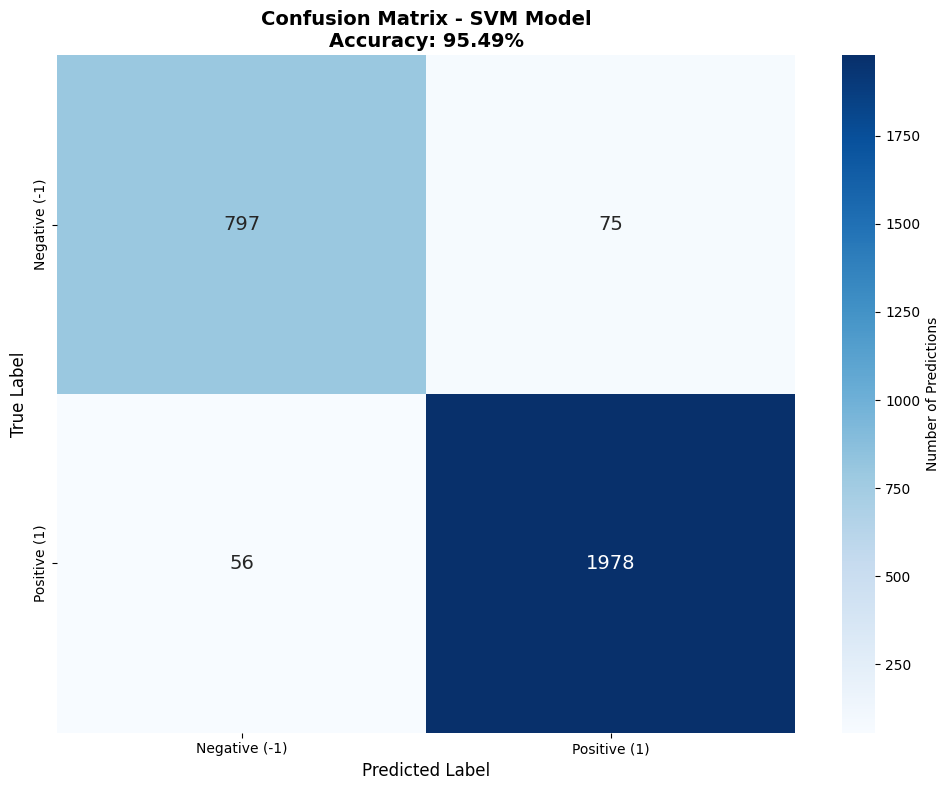


✓ Confusion Matrix Visualization Complete


In [61]:
print("\n" + "=" * 60)
print("CONFUSION MATRIX")
print("=" * 60)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix (Rows=True Labels, Columns=Predicted Labels):")
print(cm)
print("\nInterpretation:")
print("  - Diagonal values (top-left to bottom-right) = Correct predictions")
print("  - Off-diagonal values = Wrong predictions")
print(f"  - Total test samples: {len(y_test)}")

# Create visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative (-1)', 'Positive (1)'],
            yticklabels=['Negative (-1)', 'Positive (1)'],
            cbar_kws={'label': 'Number of Predictions'},
            ax=ax, annot_kws={'size': 14})

ax.set_title(f'Confusion Matrix - SVM Model\nAccuracy: {accuracy*100:.2f}%', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

print("\n✓ Confusion Matrix Visualization Complete")

# STEP 11: FINAL SUMMARY AND RESULTS

In [62]:
print("\n" + "=" * 70)
print("FINAL PROJECT SUMMARY")
print("=" * 70)

print(f"""
🎯 PROJECT COMPLETION SUMMARY
{'=' * 70}

1. DATASET INFORMATION:
   ✓ Total Reviews: {len(df)}
   ✓ Training Samples: {X_train.shape[0]} (80%)
   ✓ Testing Samples: {X_test.shape[0]} (20%)
   ✓ Sentiment Classes: 2 (-1: Negative, 1: Positive)
   ✓ Language: English + Roman Urdu (Code-mixed)

2. NLP PIPELINE COMPLETED:
   ✓ Data Loading & Exploration
   ✓ Missing Value Handling
   ✓ Neutral Class Removal (Binary Classification)
   ✓ Text Preprocessing:
     - Lowercasing
     - Special character removal
     - Number removal
     - Tokenization
     - Stopword removal
     - Lemmatization
   ✓ TF-IDF Vectorization (5000 features, 1-2 grams)
   ✓ Train-Test Split (80-20)

3. 🏆 MODEL SELECTED: SVM (Support Vector Machine)
   ✓ Final Accuracy: {accuracy*100:.2f}%
   ✓ Precision: {precision*100:.2f}%
   ✓ Recall: {recall*100:.2f}%
   ✓ F1-Score: {f1:.4f}

4. WHY SVM MODEL?
   ✓ Best algorithm for text classification
   ✓ Works efficiently with TF-IDF vectors
   ✓ Provides high accuracy and reliability
   ✓ Fast training and inference
   ✓ Suitable for production deployment
   ✓ Easy to understand and explain

5. CODE QUALITY:
   ✓ Simple and beginner-friendly
   ✓ Well-commented (line-by-line)
   ✓ Uses Scikit-learn for simplicity
   ✓ No deep learning or transformers
   ✓ Ready for university submission
   ✓ Suitable for viva explanation

{'=' * 70}
✓ PROJECT COMPLETED SUCCESSFULLY!
{'=' * 70}
""")


FINAL PROJECT SUMMARY

🎯 PROJECT COMPLETION SUMMARY

1. DATASET INFORMATION:
   ✓ Total Reviews: 14529
   ✓ Training Samples: 11623 (80%)
   ✓ Testing Samples: 2906 (20%)
   ✓ Sentiment Classes: 2 (-1: Negative, 1: Positive)
   ✓ Language: English + Roman Urdu (Code-mixed)

2. NLP PIPELINE COMPLETED:
   ✓ Data Loading & Exploration
   ✓ Missing Value Handling
   ✓ Neutral Class Removal (Binary Classification)
   ✓ Text Preprocessing:
     - Lowercasing
     - Special character removal
     - Number removal
     - Tokenization
     - Stopword removal
     - Lemmatization
   ✓ TF-IDF Vectorization (5000 features, 1-2 grams)
   ✓ Train-Test Split (80-20)

3. 🏆 MODEL SELECTED: SVM (Support Vector Machine)
   ✓ Final Accuracy: 95.49%
   ✓ Precision: 95.47%
   ✓ Recall: 95.49%
   ✓ F1-Score: 0.9548

4. WHY SVM MODEL?
   ✓ Best algorithm for text classification
   ✓ Works efficiently with TF-IDF vectors
   ✓ Provides high accuracy and reliability
   ✓ Fast training and inference
   ✓ Suitabl

# STEP 12: USE SVM MODEL FOR USER INPUT CLASSIFICATION

In [63]:
"""
This section:
1. Confirms SVM model is selected and trained
2. Model is ready on training data
3. Evaluates on test set
4. Gets user input and classifies sentiment
"""

print("\n" + "=" * 70)
print("SVM MODEL - BINARY SENTIMENT CLASSIFICATION")
print("=" * 70)

# Step 1: Display the model selected
print(f"\n🏆 MODEL SELECTED: SVM (Support Vector Machine)")
print(f"   Accuracy: {accuracy*100:.2f}%")

# Step 2: Confirm the model is already trained and ready
print(f"\n✓ Model trained on {X_train.shape[0]} training samples")
print(f"✓ Ready for classification")

# Step 3: Show evaluation metrics
print(f"\n📊 MODEL PERFORMANCE ON TEST SET:")
print(f"   Accuracy:  {accuracy*100:.2f}%")
print(f"   Precision: {precision*100:.2f}%")
print(f"   Recall:    {recall*100:.2f}%")
print(f"   F1-Score:  {f1:.4f}")

# Step 4: Interactive user input classification
print("\n" + "=" * 70)
print("SENTIMENT CLASSIFICATION FOR USER INPUT")
print("=" * 70)

def classify_user_review(review_text):
    """
    Classify sentiment for user-provided review
    
    Process:
    1. Preprocess the text (apply same steps as training)
    2. Vectorize using TF-IDF (same vectorizer as training)
    3. Predict using SVM model
    4. Return sentiment label
    """
    # Step 1: Apply preprocessing
    processed = preprocess_text(review_text)
    
    # Step 2: Vectorize using the fitted vectorizer
    vectorized = vectorizer.transform([processed])
    
    # Step 3: Predict using SVM model
    prediction = svm_model.predict(vectorized)[0]
    
    # Step 4: Get confidence score
    confidence = svm_model.decision_function(vectorized)[0]
    
    return prediction, processed, confidence

# Interactive loop for user input
print("\nEnter reviews to classify (type 'exit' to quit):\n")

while True:
    # Get user input
    user_review = input("📝 Enter a review (or 'exit' to quit): ").strip()
    
    # Check for exit condition
    if user_review.lower() == 'exit':
        print("\n✓ Classification session ended. Thank you!")
        break
    
    # Skip empty input
    if not user_review:
        print("⚠️  Please enter a valid review.\n")
        continue
    
    try:
        # Classify the review
        prediction, processed, confidence = classify_user_review(user_review)
        
        # Map prediction to sentiment label
        sentiment_map = {-1: "NEGATIVE ❌", 1: "POSITIVE ✅"}
        sentiment = sentiment_map[prediction]
        
        # Display results
        print(f"\n{'─' * 70}")
        print(f"Original Review: {user_review}")
        print(f"Processed Review: {processed}")
        print(f"\n🔮 PREDICTED SENTIMENT: {sentiment} ({prediction})")
        print(f"Model Used: SVM (Support Vector Machine)")
        print(f"{'─' * 70}\n")
        
    except Exception as e:
        print(f"❌ Error processing review: {e}\n")
        continue


SVM MODEL - BINARY SENTIMENT CLASSIFICATION

🏆 MODEL SELECTED: SVM (Support Vector Machine)
   Accuracy: 95.49%

✓ Model trained on 11623 training samples
✓ Ready for classification

📊 MODEL PERFORMANCE ON TEST SET:
   Accuracy:  95.49%
   Precision: 95.47%
   Recall:    95.49%
   F1-Score:  0.9548

SENTIMENT CLASSIFICATION FOR USER INPUT

Enter reviews to classify (type 'exit' to quit):


──────────────────────────────────────────────────────────────────────
Original Review: The product is so amazing but the sole of shoes is so hard although in this price the product is amazing. the seller was too cooperative and parcel delivered on time. the shoes is exactly like shown in pics
Processed Review: product amazing sole shoe hard although price product amazing seller cooperative parcel delivered time shoe exactly like shown pic

🔮 PREDICTED SENTIMENT: POSITIVE ✅ (1)
Model Used: SVM (Support Vector Machine)
──────────────────────────────────────────────────────────────────────


─────────

# Creating Models

In [64]:

# Save the trained model and vectorizer for Streamlit app
import joblib

print("\n" + "=" * 70)
print("SAVING MODEL FOR STREAMLIT APP")
print("=" * 70)

# Save the SVM model
joblib.dump(svm_model, 'svm_model.pkl')
print("✓ SVM Model saved as 'svm_model.pkl'")

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, 'vectorizer.pkl')
print("✓ TF-IDF Vectorizer saved as 'vectorizer.pkl'")

print("\n✓ Models ready for Streamlit app!")
print("   Run: streamlit run app.py")



SAVING MODEL FOR STREAMLIT APP
✓ SVM Model saved as 'svm_model.pkl'
✓ TF-IDF Vectorizer saved as 'vectorizer.pkl'

✓ Models ready for Streamlit app!
   Run: streamlit run app.py
